In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import time
import warnings
import numpy as np
from nltk.corpus import stopwords
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, log_loss
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier 
from collections import Counter
from scipy.sparse import hstack
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold 
from collections import Counter, defaultdict
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import math
from sklearn.metrics import normalized_mutual_info_score
from sklearn.ensemble import RandomForestClassifier
warnings.filterwarnings("ignore")
import six
import sys
sys.modules['sklearn.externals.six'] = six
from mlxtend.classifier import StackingClassifier
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression

In [12]:
%load_ext autoreload
%autoreload 2

In [2]:


data = pd.read_csv('data/training_variants/training_variants.csv')
print('Number of data points : ', data.shape[0])
print('Number of features : ', data.shape[1])
print('Features : ', data.columns.values)
data.head()

data_text =pd.read_csv("data/training_text/training_text.csv",sep="\|\|",engine="python",names=["ID","TEXT"],skiprows=1)
print('Number of data points : ', data_text.shape[0])
print('Number of features : ', data_text.shape[1])
print('Features : ', data_text.columns.values)
data_text.head()

Number of data points :  3321
Number of features :  4
Features :  ['ID' 'Gene' 'Variation' 'Class']
Number of data points :  3321
Number of features :  2
Features :  ['ID' 'TEXT']


,ID,TEXT
0,0,Cyclin-dependent kinases (CDKs) regulate a var...
1,1,Abstract Background Non-small cell lung canc...
2,2,Abstract Background Non-small cell lung canc...
3,3,Recent evidence has demonstrated that acquired...
4,4,Oncogenic mutations in the monomeric Casitas B...


In [3]:
import nltk
nltk.download('stopwords')

# loading stop words from nltk library
stop_words = set(stopwords.words('english'))


def nlp_preprocessing(total_text, index, column):
    if type(total_text) is not int:
        string = ""
        # replace every special char with space
        total_text = re.sub('[^a-zA-Z0-9\n]', ' ', total_text)
        # replace multiple spaces with single space
        total_text = re.sub('\s+',' ', total_text)
        # converting all the chars into lower-case.
        total_text = total_text.lower()
        
        for word in total_text.split():
        # if the word is a not a stop word then retain that word from the data
            if not word in stop_words:
                string += word + " "
        
        data_text[column][index] = string

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\hruthik.marappa\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
import time

start_time = time.perf_counter()

for index, row in data_text.iterrows():
    if isinstance(row['TEXT'], str):
        nlp_preprocessing(row['TEXT'], index, 'TEXT')
        pass

end_time = time.perf_counter()
print(f"Elapsed time: {end_time - start_time:.4f} seconds")


Elapsed time: 35.1638 seconds


In [5]:
result = pd.merge(data, data_text,on='ID', how='left')
result.head()

,ID,Gene,Variation,Class,TEXT
0,0,FAM58A,Truncating Mutations,1,cyclin dependent kinases cdks regulate variety...
1,1,CBL,W802*,2,abstract background non small cell lung cancer...
2,2,CBL,Q249E,2,abstract background non small cell lung cancer...
3,3,CBL,N454D,3,recent evidence demonstrated acquired uniparen...
4,4,CBL,L399V,4,oncogenic mutations monomeric casitas b lineag...


In [6]:
result.loc[result['TEXT'].isnull(),'TEXT'] = result['Gene'] +' '+result['Variation']

In [7]:
result.loc[result['TEXT']==result['Gene'] +' '+result['Variation'],'TEXT']

1109                   FANCA S1088F
1277    ARID5B Truncating Mutations
1407                    FGFR3 K508M
1639             FLT1 Amplification
2755                     BRAF G596C
Name: TEXT, dtype: object

In [8]:
y_true = result['Class'].values
result.Gene      = result.Gene.str.replace('\s+', '_')
result.Variation = result.Variation.str.replace('\s+', '_')

# split the data into test and train by maintaining same distribution of output varaible 'y_true' [stratify=y_true]
X_train, test_df, y_train, y_test = train_test_split(result, y_true, stratify=y_true, test_size=0.2)
# split the train data into train and cross validation by maintaining same distribution of output varaible 'y_train' [stratify=y_train]
train_df, cv_df, y_train, y_cv = train_test_split(X_train, y_train, stratify=y_train, test_size=0.2)

In [9]:
print('Number of data points in train data:', train_df.shape)
print('Number of data points in test data:', test_df.shape)
print('Number of data points in cross validation data:', cv_df.shape)

Number of data points in train data: (2124, 5)
Number of data points in test data: (665, 5)
Number of data points in cross validation data: (532, 5)


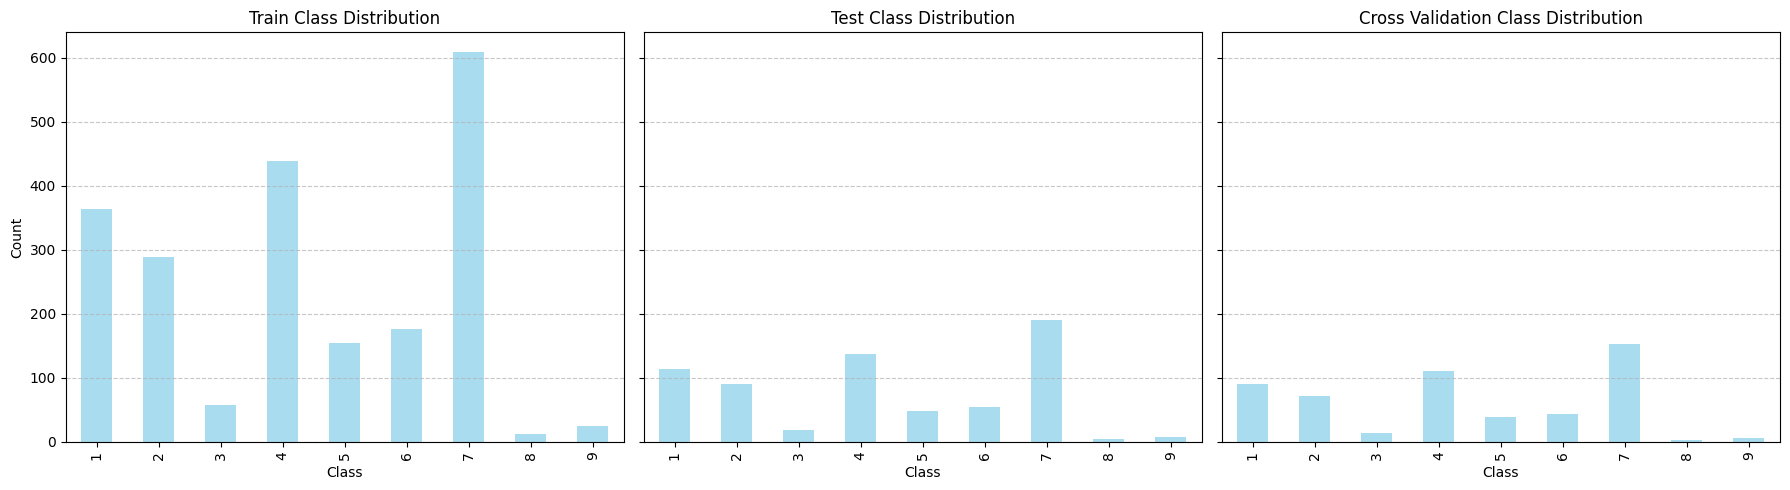

In [10]:
import matplotlib.pyplot as plt

train_class_distribution = train_df['Class'].value_counts().sort_index()
test_class_distribution = test_df['Class'].value_counts().sort_index()
cv_class_distribution = cv_df['Class'].value_counts().sort_index()

fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)

distributions = [
    (train_class_distribution, 'Train Class Distribution'),
    (test_class_distribution, 'Test Class Distribution'),
    (cv_class_distribution, 'Cross Validation Class Distribution')
]

for ax, (dist, title) in zip(axes, distributions):
    dist.plot(kind='bar', color='skyblue', alpha=0.7, ax=ax)
    ax.set_title(title)
    ax.set_xlabel('Class')
    ax.set_ylabel('Count')
    ax.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()


In [14]:

from train_model import best_parameter,predict_model

from encode import Encoder 
gene_train = Encoder().get_onehotCoding(train_df, test_df, cv_df,'Gene')[0]
gene_test = Encoder().get_onehotCoding(train_df, test_df, cv_df,'Gene')[1]
gene_cv = Encoder().get_onehotCoding(train_df, test_df, cv_df,'Gene')[2]
 

model=SGDClassifier(random_state=42, max_iter=1000)
param=[
    {'alpha': [0.0001, 0.001, 0.01], 'penalty': ['l2', 'l1'], 'loss': ['log_loss']}
]
best_parm,best_model= best_parameter(param, model, gene_train, y_train)

 
print(log_loss(y_train, predict_model(best_model, gene_train,"proba"))) 
print(log_loss(y_test, predict_model(best_model, gene_test,"proba"))) 
print(log_loss(y_cv, predict_model(best_model, gene_cv,"proba")))


0.9724171241174591
1.201677360428709
1.2346061880155266


for variation feature get_response_coding working better 

In [ ]:
from train_model import best_parameter,predict_model

from encode import Encoder 
var_train = Encoder().get_response_coding(train_df, feature='Variation')
var_test = Encoder().get_response_coding(test_df, feature='Variation')
var_cv = Encoder().get_response_coding(cv_df, feature='Variation')
 

model=SGDClassifier(random_state=42, max_iter=1000)
param=[
    {'alpha': [0.0001, 0.001, 0.01], 'penalty': ['l2', 'l1'], 'loss': ['log_loss']}
]
best_parm,best_model= best_parameter(param, model, var_train, y_train)


print(log_loss(y_train, predict_model(best_model, var_train,"proba")))
print(log_loss(y_test, predict_model(best_model, var_test,"proba")))
print(log_loss(y_cv, predict_model(best_model, var_cv,"proba")))


1.4286649930472524
1.4125144872679
1.4126788784263742


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_features=10000, ngram_range=(1, 2), stop_words='english') 
X_train_vec = vectorizer.fit_transform(train_df["TEXT"]) 
X_cv_vec = vectorizer.transform(cv_df["TEXT"])
X_test_vec = vectorizer.transform(test_df["TEXT"])


In [ ]:

model=SGDClassifier(random_state=42, max_iter=1000)
param=[
    {'alpha': [0.0001, 0.001, 0.01], 'penalty': ['l2', 'l1'], 'loss': ['log_loss']}
]
best_parm,best_model= best_parameter(param, model, X_train_vec, y_train)

print(log_loss(y_train, predict_model(best_model, X_train_vec,"proba")))
print(log_loss(y_test, predict_model(best_model, X_test_vec,"proba")))
print(log_loss(y_cv, predict_model(best_model, X_cv_vec,"proba"))) 


0.670363086610034
1.0364955523712205
1.124347542714619


In [ ]:
from scipy.sparse import hstack
from scipy.sparse import csr_matrix

# Convert dense array to sparse
var_train_sparse = csr_matrix(var_train)

# Horizontally stack all sparse matrices
x_train = hstack([X_train_vec, var_train_sparse, gene_train])
x_cv = hstack([X_cv_vec, csr_matrix(var_cv), gene_cv])
x_test= hstack([X_test_vec, csr_matrix(var_test), gene_test])


In [ ]:
model=SGDClassifier(random_state=42, max_iter=1000)
param=[
    {'alpha': [0.0001, 0.001, 0.01,0.1], 'penalty': ['l2', 'l1'], 'loss': ['log_loss']}
]
best_parm,best_model= best_parameter(param, model, x_train, y_train)

print(log_loss(y_train, predict_model(best_model, x_train,"proba")))
print(log_loss(y_test, predict_model(best_model, x_test,"proba")))
print(log_loss(y_cv, predict_model(best_model, x_cv,"proba"))) 


0.5271411037488699
0.9007668925409809
0.9972904937524746


665 665
-------------------- Confusion matrix --------------------


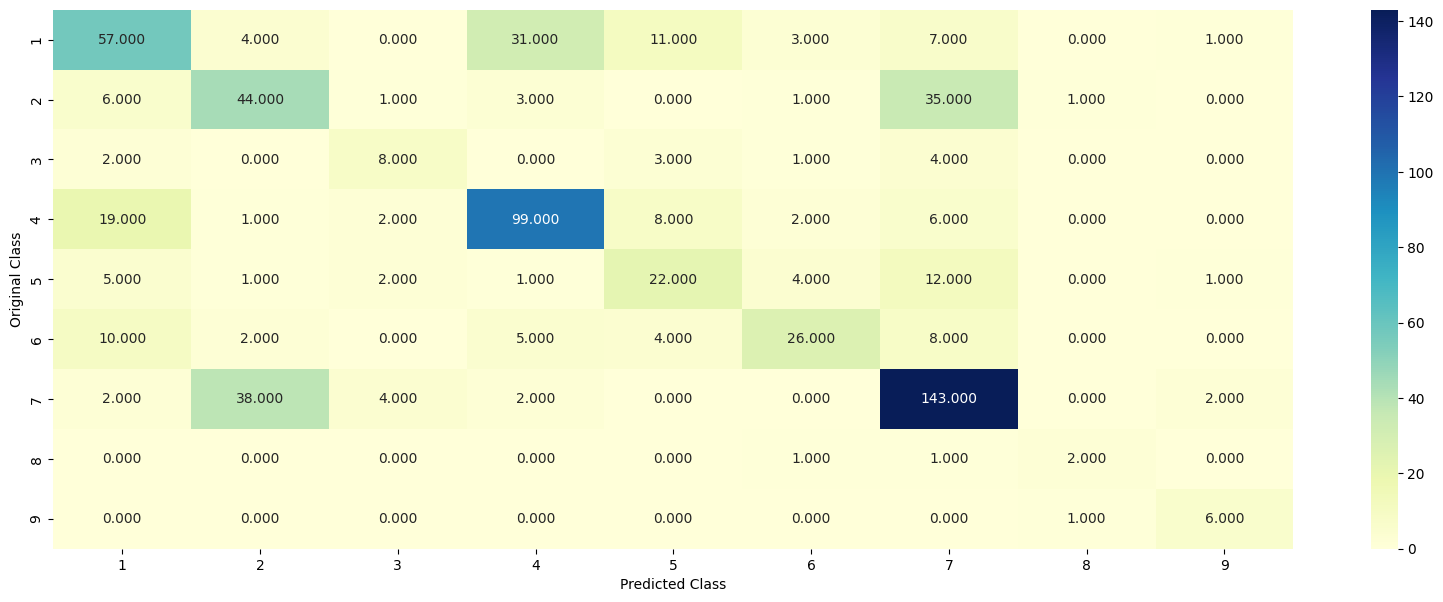

-------------------- Precision matrix (Columm Sum=1) --------------------


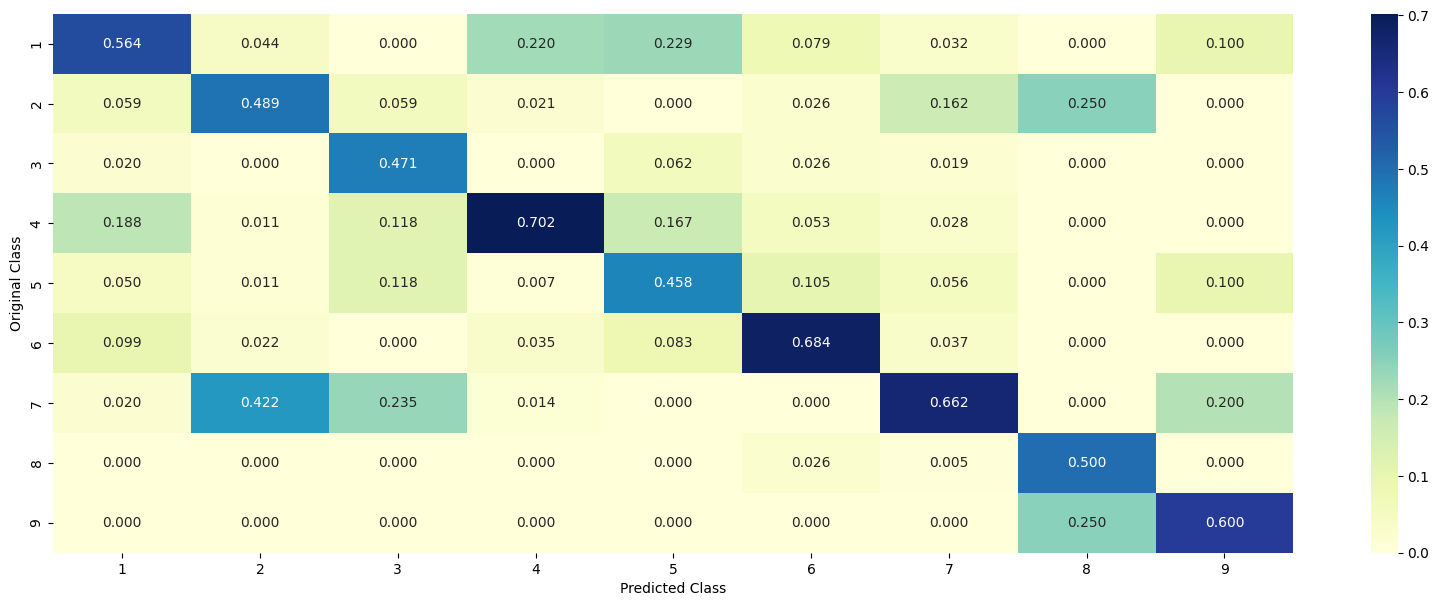

-------------------- Recall matrix (Row sum=1) --------------------


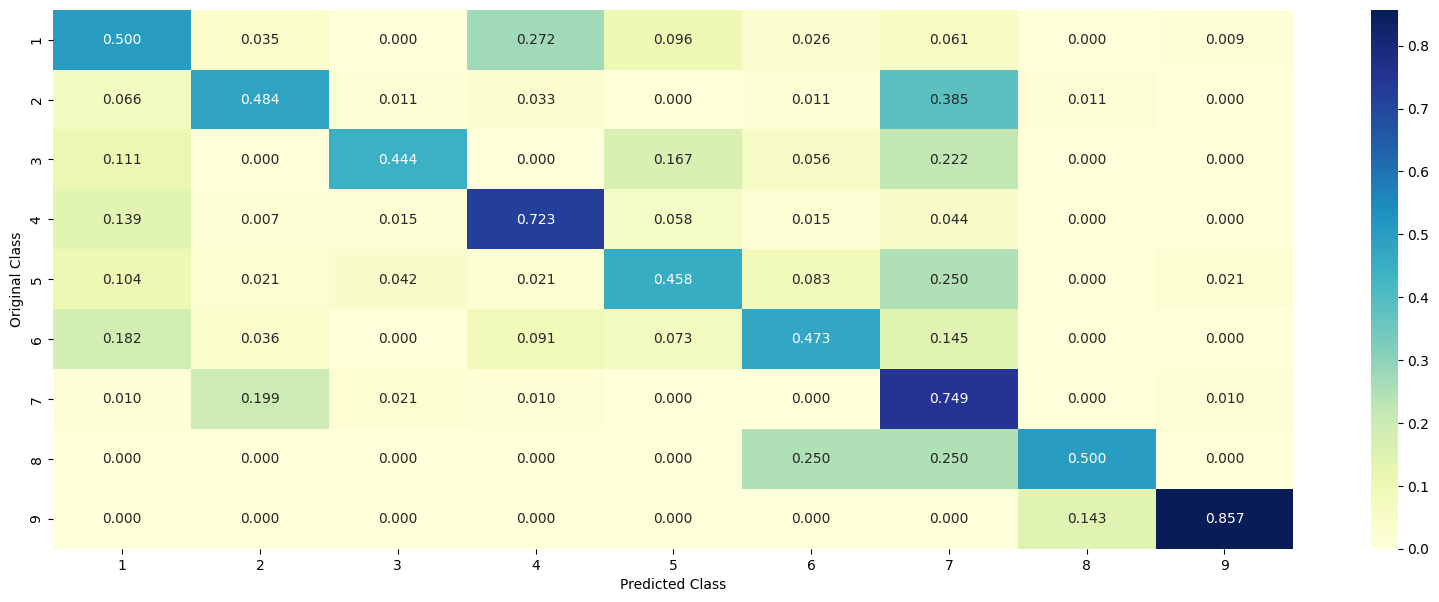

In [ ]:
from visual import plot_confusion_matrix

y_pred=predict_model(best_model, x_test,"predict")

plot_confusion_matrix(y_test, y_pred)

In [ ]:
len(y_pred),len(y_test)

(665, 665)

In [ ]:
model=MultinomialNB( )
param=[
    {
    'alpha': [0.0001, 0.001, 0.01,0.1, 0.11],
    'fit_prior': [True, False]
}
]
best_parm,best_model= best_parameter(param, model, x_train, y_train)

print(log_loss(y_train, predict_model(best_model, x_train,"proba")))
print(log_loss(y_test, predict_model(best_model, x_test,"proba")))
print(log_loss(y_cv, predict_model(best_model, x_cv,"proba"))) 


1.3354848985610928
2.8673644347996574
3.298614821036875
